In [22]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
# Imports and environment configuration
import time
import datetime
import math
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import mixed_precision

import numpy as np
import pathlib
import os

# env config
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "false"
os.environ["TF_GPU_ALLOCATOR"] = ""

# gpu training optimization
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# tensorboard config
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

In [24]:
# Variables
epochs = 25
montecarlo_iterations = 20
batch_size = 64
img_height = 64
img_width = 64


In [25]:
# Hyper Parameters 
HP_NUM_CONV_UNITS = hp.HParam('num_conv_units', hp.Discrete([8, 16]))
HP_NUM_DENSE_UNITS = hp.HParam('num_dense_units', hp.Discrete([16, 32, 64, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.7))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['Adam']))

METRIC_ACCURACY = 'accuracy'
METRIC_STD = 'std'


# Hyper parameters
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
      hparams=[HP_NUM_CONV_UNITS, HP_NUM_DENSE_UNITS,
               HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy'),
             hp.Metric(METRIC_STD, display_name='STD')],
  )

In [26]:
# Model definition

# custom layers
# data augmentation layers (training only)
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal",
                                   input_shape=(img_height,
                                                img_width,
                                                3)),
        tf.keras.layers.RandomRotation(0.25),
        tf.keras.layers.RandomZoom(0.25),
    ]
)


def create_model(hparams):
    model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.layers.Rescaling(
            1./255, input_shape=(img_height, img_width, 3)),

        tf.keras.layers.Conv2D(hparams[HP_NUM_CONV_UNITS], 3, activation='relu',),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            hparams[HP_NUM_CONV_UNITS] * 2, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            hparams[HP_NUM_CONV_UNITS] * 3, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(hparams[HP_NUM_DENSE_UNITS], activation='relu'),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(hparams[HP_OPTIMIZER],
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [27]:
def train_model(model, train_ds, val_ds, model_name=""):
    # model.fit(train_ds, epochs=epochs, callbacks=[tensorboard_callback])
    model.fit(train_ds, epochs=epochs, callbacks=[tf.keras.callbacks.TensorBoard(log_dir=log_dir + model_name, histogram_freq=1)])
    _, accuracy = model.evaluate(val_ds)
    return accuracy                  

In [28]:
# Monte carlo cross validation

data_path = "/tf/data/train"
data_dir = pathlib.Path(data_path)
test_dir = pathlib.Path("/tf/data/test")


def MCCV(model, hparams, hparams_log_dir):

    all_scores = []

    # Monte carlo cross validation
    for i in range(montecarlo_iterations):
        # truly random dataset
        seed = math.ceil(time.time())
        # training dataset
        train_ds = tf.keras.utils.image_dataset_from_directory(
                data_dir,
                validation_split=0.2,
                subset="training",
                seed=seed,
                image_size=(img_height, img_width),
                batch_size=batch_size)
        # validation dataset 
        val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="validation",
            seed=seed,
            image_size=(img_height, img_width),
            batch_size=batch_size)

        # test_ds = tf.keras.utils.image_dataset_from_directory(
        #     test_dir,
        #     seed=seed,
        #     image_size=(img_height, img_width),
        #     batch_size=batch_size)
        LOG_NAME = "model-{}-{}-{}".format(hparams[HP_NUM_CONV_UNITS], hparams[HP_NUM_DENSE_UNITS], hparams[HP_DROPOUT])
        accuracy = train_model(model, train_ds, val_ds, model_name=LOG_NAME)
        all_scores.append(accuracy)

    with tf.summary.create_file_writer(hparams_log_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        tf.summary.scalar(METRIC_ACCURACY, np.mean(all_scores), step=1)
        # tf.summary.scalar(METRIC_ACCURACY, all_scores, step=1)
        tf.summary.scalar(METRIC_STD, np.std(all_scores), step=1)
    
    return (np.mean(all_scores), np.std(all_scores))



In [29]:
def grid_search():
    model_performance = []
    session_num = 0
    for num_conv_units in HP_NUM_CONV_UNITS.domain.values:
        for num_dense_units in HP_NUM_DENSE_UNITS.domain.values:
            for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
                for optimizer in HP_OPTIMIZER.domain.values:
                    hparams = {
                        HP_NUM_CONV_UNITS: num_conv_units,
                        HP_NUM_DENSE_UNITS: num_dense_units,
                        HP_DROPOUT: dropout_rate,
                        HP_OPTIMIZER: optimizer,
                    }
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    model = create_model(hparams)
                    metrics = MCCV(model, hparams, 'logs/hparam_tuning/' + run_name)
                    model_performance.append(metrics)
                    session_num += 1

    return (model_performance, session_num)


In [30]:
models_performances, sessions = grid_search()

--- Starting trial: run-0
{'num_conv_units': 8, 'num_dense_units': 16, 'dropout': 0.1, 'optimizer': 'Adam'}
Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Epoch 1/10
30/30 [==============================] - 1s 6ms/step - loss: 0.6538 - accuracy: 0.5875
Epoch 2/10
30/30 [==============================] - 0s 6ms/step - loss: 0.5919 - accuracy: 0.6969
Epoch 3/10
30/30 [==============================] - 0s 5ms/step - loss: 0.5658 - accuracy: 0.7167
Epoch 4/10
30/30 [==============================] - 0s 6ms/step - loss: 0.5537 - accuracy: 0.7260
Epoch 5/10
30/30 [==============================] - 0s 5ms/step - loss: 0.5110 - accuracy: 0.7521
Epoch 6/10
30/30 [==============================] - 0s 6ms/step - loss: 0.4881 - accuracy: 0.7625
Epoch 7/10
30/30 [==============================] - 0s 5ms/step - loss: 0.4393 - accuracy: 0.7969
Epoch 8/10
30/30 [==============================] - 0s 5ms/st

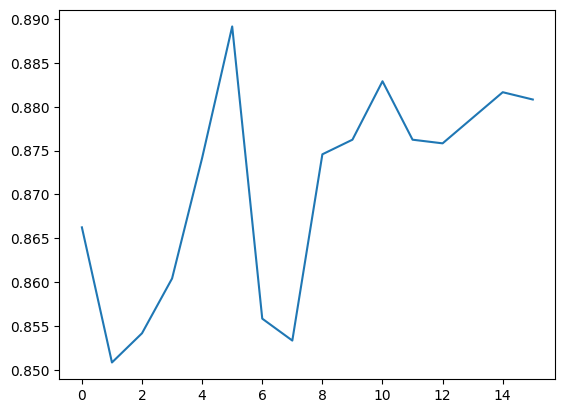

In [31]:
from matplotlib import pyplot as plt

plt.plot(list(range(0 ,len(models_performances))), [x[0] for x in models_performances])
plt.show()

In [32]:
# %tensorboard --logdir logs/fit --bind_all --port 6008


In [33]:
# %tensorboard --logdir logs/hparam_tuning --bind_all --port 6007